In [10]:

using TOML
using CSV
using DataFrames
using Distributions

In [47]:
# Define a function to generate datasets based on the TOML configuration
function generate_datasets(dataset_name::String)
    # Load configuration from TOML file
    config = TOML.parsefile("./equations.toml")

    # Retrieve general parameters
    num_samples = config["general"]["num_samples"]

    # Retrieve function-specific parameters for the specified dataset
    dataset_config = config[dataset_name]

    # Retrieve equation and constants
    equation_str = dataset_config["equation"]
    constants_config = dataset_config["constants"]

    # Define a function using the provided equation
    function equation_function(features, constants, data)
        # Extract constants
        for (name, value) in constants
            eval(Meta.parse("const $name = $value"))
            equation_str = replace(equation_str, string(name) => string(value))
        end
        # Evaluate the equation string within the context of this function
        println(equation_str)
        for (feature_name, _) in features
            eval(Meta.parse("$feature_name = $(data[!, Symbol(feature_name)])"))       
        end
        eval(Meta.parse(equation_str))
    end

    # Generate data for each feature
    data = DataFrame()
    for (feature_name, feature_params) in dataset_config["features"]
        feature_min = feature_params["min"]
        feature_max = feature_params["max"]
        feature_data = rand(Uniform(feature_min, feature_max), num_samples)
        data[!, Symbol(feature_name)] = feature_data
    end

    println(size(data))
    # Calculate the dependent variable using the equation function
    dependent_variable = equation_function(dataset_config["features"], constants_config, data)

    #Add noise to the dependent variable
    
    noise = rand(Normal(0, 1), num_samples)
    scale = dataset_config["noise_scale"]
    dependent_variable += noise.*dependent_variable.*scale

    # Add dependent variable to the DataFrame
    data[!, :y] = dependent_variable

    # Save to CSV
    output_file = "./data/SCBench/$dataset_name.csv"
    CSV.write(output_file, data)
    println("Data generated and saved to $output_file")
end


# Generate dataset
generate_datasets("light")


(1000, 3)
(x .- u .* t) ./ (sqrt.(1 .- u.^2 ./ 2.99792458e8.^2))
Data generated and saved to ./data/SCBench/light.csv


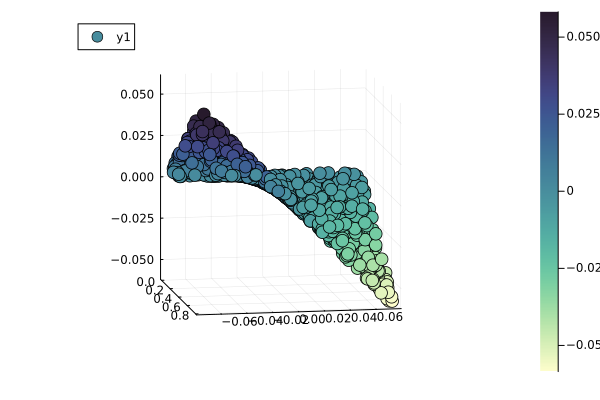

In [48]:
#scatter x, I and y of the magman data
using Plots

magman = CSV.read("./data/SCBench/magman.csv", DataFrame)


plt3d= Plots.plot(magman.I, magman.x, magman.y,
     seriestype=:scatter, markersize = 7, zcolor = magman.y, colormap = :deep, camera = (80, 10))
display(plt3d)